In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from pytorchtools_FCFF_particles import EarlyStopping

from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import scipy.stats as st

from matplotlib.offsetbox import AnchoredText

In [11]:
#GPU
device = "cuda:1" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using cuda:1 device


In [25]:
class FCFF(nn.Module):

    def __init__(self,p, neg_slope):
        super(FCFF, self).__init__()
        self.NN = nn.Sequential(
          
            # nn.Linear(784, 784, dtype = torch.double, device = device),
            # nn.BatchNorm1d(784, dtype = torch.double),
            # nn.Dropout1d(p = p),
            # nn.LeakyReLU(neg_slope),
            
            nn.Linear(48, 30, dtype = torch.double, device = device),
            nn.BatchNorm1d(30, dtype = torch.double),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(30, 15, dtype = torch.double, device = device),
            nn.BatchNorm1d(15, dtype = torch.double),
            nn.Dropout1d(p = p),
            nn.LeakyReLU(neg_slope),

            nn.Linear(15, 2, dtype = torch.double,  device = device),
        )
        
        #self._init_weights(self.NN)
        #nn.Sequential.apply(_init_weights)
        self.apply(self._init_weights)
    
    def _init_weights(self,module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, 0, 0.1)
            if module.bias is not None:
                module.bias.data.fill_(0.08)

    def forward(self, x1, x2):

        x1 = torch.flatten(x1, 1)
        x1 = self.NN(x1)

        x2 = torch.flatten(x2, 1)
        x2 = self.NN(x2)
        
        return torch.stack([x1, x2])

In [13]:
class MyLoss (nn.Sequential):
    def __init__(self):
        super(MyLoss, self).__init__()

    def forward(self, W, E):
        
        xw, yw = torch.nonzero(W, as_tuple = True)
        
        W = W[xw,yw]
        E = E[xw,yw]

        loss = torch.mean(torch.abs(E-W)/W).to(device)
        
        return loss

In [14]:
def Reg_Loss(loss, LAMBDA):
    
    l_reg = 0
    for W in model.parameters():
        l_reg = l_reg + torch.norm(W, 1)
    
    loss_reg = loss + LAMBDA*l_reg
    
    return loss_reg

In [15]:
def Dist(W, E):
    
    x, y = torch.nonzero(W, as_tuple = True)
    
    W = W[x,y]
    E = E[x,y]
    
    dist = E/W
    
    return dist

Validation loss decreased (inf --> 0.367191).  Saving model ...
Validation loss decreased (0.367191 --> 0.343087).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.343087 --> 0.333817).  Saving model ...
Validation loss decreased (0.333817 --> 0.318941).  Saving model ...
Validation loss decreased (0.318941 --> 0.297407).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.297407 --> 0.296841).  Saving model ...
Validation loss decreased (0.296841 --> 0.290723).  Saving model ...
Validation loss decreased (0.290723 --> 0.288607).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.288607 --> 0.273956).  Saving model ...
Validation loss decreased (0.273956 --> 0.272176).  Saving model ...
EarlyStopping counter: 1 out of 30
Validation loss decreased (0.272176 --> 0.262491).  Saving model ...
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 2 out of 30
EarlyStopping counter: 3 out of 30
E

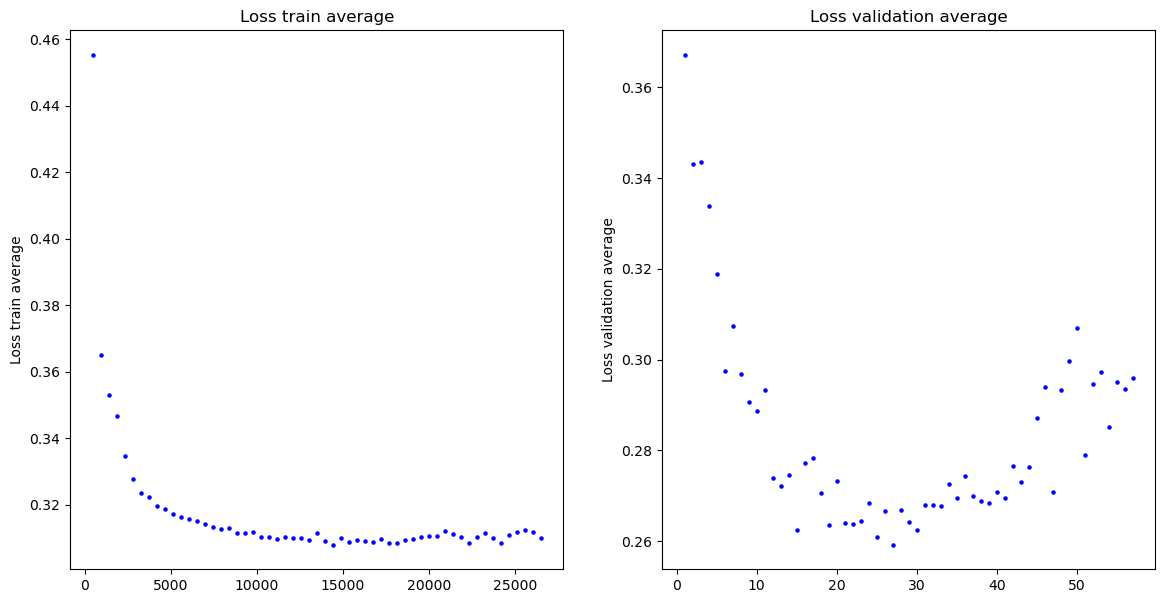

In [36]:
#Dataloder

train, targets_train = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_train', map_location=device)
validation, targets_validation = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_validation', map_location=device)
train = train.double()

W_dist_train, tagets_train = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_train_s=12000', map_location=device)
W_dist_validation, targets_validation = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_validation_s=2400', map_location=device)

#validation = validation.view(W_dist_validation.size(0), 1, validation.size(1), validation.size(2)).double()

#parameters

n_sample_train = train.size(0)
n_sample_validation = validation.size(0)

batch_size = 400#200#100

n_batches_train = int(n_sample_train/batch_size)
n_batches_validation = int(n_sample_validation/batch_size)

train = torch.stack(torch.chunk(train, n_batches_train, dim = 0), dim = 0)#.view(n_batches_train, batch_size, 1, 16, 3)
W_dist_train = torch.stack(torch.chunk(torch.stack(torch.chunk(W_dist_train, n_batches_train, dim = -1), dim = 0), n_batches_train, dim = 1), dim = 0)

#Train
#-----------------------------------------------------------------------------------------------------------SETTING
learning_rate = 1e-2

criterion = MyLoss()
#criterion = nn.MSELoss()

LAMBDA = 0

patience = 30

iteration = 1000

counter_train = 0 
counter_validation = 0

neg_slope = 0.01


p = 0.1

model = FCFF(p, neg_slope).to(device)

optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay = 0)#, betas=(0.9, 0.99), eps=1e-5 ,weight_decay=0)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.7)


fig = plt.figure(figsize = (14, 7), constrained_layout=False)
gs = GridSpec(1, 2, figure = fig)

ax3 = fig.add_subplot(gs[0, 0])
ax3.set_title('Loss train average')
ax3.set_ylabel('Loss train average')
ax3.set_ybound(lower = 0, upper = None)

ax4 = fig.add_subplot(gs[0, 1])
ax4.set_title('Loss validation average')
ax4.set_ylabel('Loss validation average')
ax4.set_ybound(lower = 0, upper = None)

#ax5 = fig.add_subplot(gs[0, 0])
#ax5.set_title('Distortion validation')
#ax5.set_ylabel('Distortion')
#ax5.axvline(x=1, color='r', linestyle='-')
#ax5.set_xlim(-0.1, 4)
#ax5.set_ylim(-0.1, 0.5)

#fig.suptitle("MNIST and lr= "+str(learning_rate)+'p value is:'+str(p)+'la loss é:MyLoss')

train_losses = []
valid_losses = []
modes = []

early_stopping = EarlyStopping(patience=patience, verbose=True)#pure lui 
#---------------------------------------------------------------------------------NN
for ite in range (iteration):
    #Train
    #---------------------------------------------------------------------------TRAIN
    model.train()
    batch_x = 0
    batch_y = 0
    for batch_x in range (n_batches_train):
        for batch_y in range (n_batches_train):
            if torch.count_nonzero(W_dist_train[batch_x][batch_y]) != 0:
                #embedding
                sample_emb_train = model(train[batch_x], train[batch_y]).to(device)

                E_dist_train = torch.cdist(sample_emb_train[0], sample_emb_train[1], p = 2).to(device)

                loss = criterion(W_dist_train[batch_x][batch_y], E_dist_train).to(device)
                loss_reg = Reg_Loss(loss, LAMBDA)
                
                train_losses.append(loss_reg.item())
                counter_train = counter_train + 1

                optimizer.zero_grad()
                loss_reg.requires_grad_()
                loss_reg.backward(retain_graph=True)

                optimizer.step()

#----------------------------------------------------------------------------------------------------------------------VALIDATION
    train_loss = np.average(train_losses)
    ax3.scatter(counter_train, train_loss, color = 'b', s=5)    
    #Validation
    model.eval()
    #embedding
    sample_emb_validation = model(validation, validation).to(device)

    E_dist_validation = torch.cdist(sample_emb_validation[0], sample_emb_validation[0], p = 2).to(device)
    
    valid_loss = criterion(W_dist_validation, E_dist_validation).to(device)
    valid_dist = Dist(W_dist_validation, E_dist_validation)
    # valid_loss_reg = Reg_Loss(valid_loss, LAMBDA)

    counter_validation = counter_validation+1



#------------------------------------------------------------------------------------------PLOT
    ax4.scatter(counter_validation, valid_loss.cpu().detach().numpy(), color = 'b', s=5)


    train_losses = []

    early_stopping(valid_loss, model)
    scheduler.step()


    if early_stopping.early_stop:
            print("Early stopping")
            break

In [37]:
test, targets_test = torch.load('/home/gbortolai/Thesis/data/Jets/dataset_test', map_location=device)
W_dist_test, target_test = torch.load('/home/gbortolai/Thesis/data/Jets/Wasserstein_dist_test_s=4000', map_location=device)

# test = test.view(W_dist_test.size(0), 1, test.size(1), test.size(2))

criterion = MyLoss()

neg_slope = 1e-2
p = 0.1

model = FCFF(p, neg_slope).to(device)

#test 
model.load_state_dict(torch.load('/home/gbortolai/Thesis/Checkpoint/checkpoint_FCFF-particles.pth'))
#-----------------------------------------------------------------------------------SETTING
model.eval()
#--------------------------------------------------------------------------------------EMBEDDING

sample_emb_test, sample_emb_test2 = model(test, test).to(device)

E_dist_test = torch.cdist(sample_emb_test, sample_emb_test2, p = 2).to(device)

test_loss = criterion(W_dist_test, E_dist_test)
test_dist = Dist(W_dist_test, E_dist_test)

test_dist_mean = torch.mean(test_dist)
var_test = np.sqrt(torch.mean((1-test_dist_mean)*(1-test_dist_mean)).cpu().detach().numpy())

test_median = torch.median(test_dist)

print('Dist mean:', test_dist_mean.item(),u"\u00B1", var_test.item())

Dist mean: 0.8076208947008245 ± 0.19237910529917546


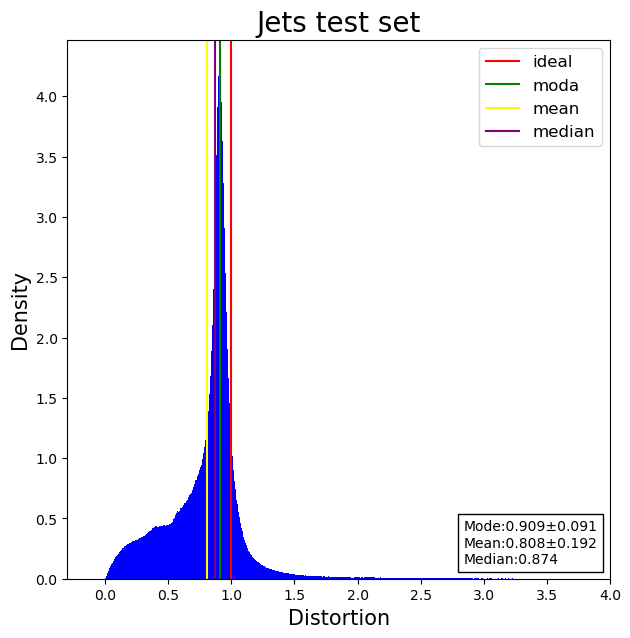

In [38]:
fig3, ax3_test = plt.subplots(1,1, figsize=(7,7))

ax3_test.set_title('Jets test set', fontsize = 20)
ax3_test.set_xlabel("Distortion", fontsize = 15)
ax3_test.set_ylabel("Density", fontsize = 15)

ax3_test.set_xlim([-0.3,4])
labels = ['ideal', 'moda', 'mean', 'median']
#plt.axhline(y=1, color='r', linestyle='-')
#for i in range(targets_test.size(0)):
    #if targets_test[i] == 2:
count_test, bins_test, p_test = ax3_test.hist(test_dist.cpu().detach().numpy(), color = 'b', bins = 'auto', density = True)
ax3_test.axvline(x=1, color='r', linestyle='-')

mode_index_test = count_test.argmax()
mode_test = (bins_test[mode_index_test] + bins_test[mode_index_test+1])/2
var_mode_test = np.sqrt(np.average((1-mode_test)*(1-mode_test)))

ax3_test.axvline(x = mode_test, color='green', linestyle='-')
ax3_test.axvline(x = test_dist_mean.cpu().detach().numpy(), color='yellow', linestyle='-')
ax3_test.axvline(x = test_median.cpu().detach().numpy(), color='purple', linestyle='-')
#plt.axvline(x=test_loss.detach().numpy(), color='orange', linestyle='-')
ax3_test.legend(labels, fontsize = 12)

anchored_text_test = AnchoredText('Mode:'+str('%.3f' % mode_test.item())+u"\u00B1"+str('%.3f' % var_mode_test.item())+'\nMean:'+str('%.3f' % test_dist_mean.item())+u"\u00B1"+str('%.3f' % var_test.item())+'\nMedian:'+str('%.3f' % test_median.item()), loc='lower right')
ax3_test.add_artist(anchored_text_test)


In [14]:
fig3.savefig('/home/gbortolai/Thesis/Plot/Jets/FCFF_myloss.pdf', facecolor='w',pad_inches=0.3, transparent=True)

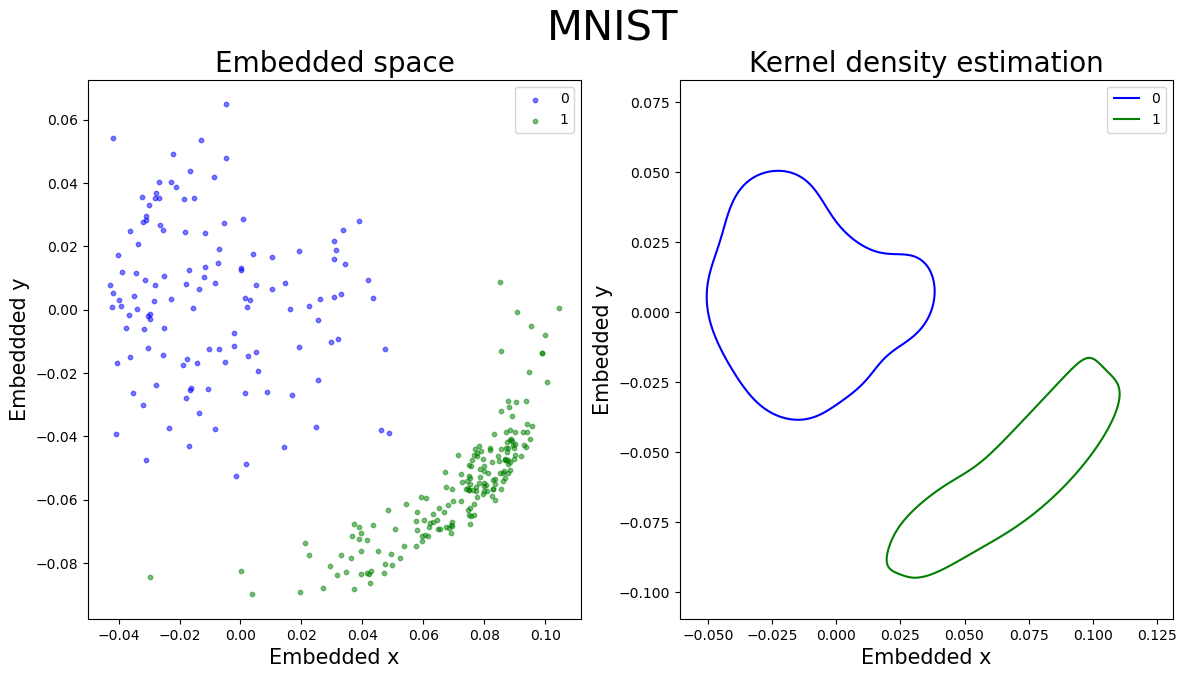

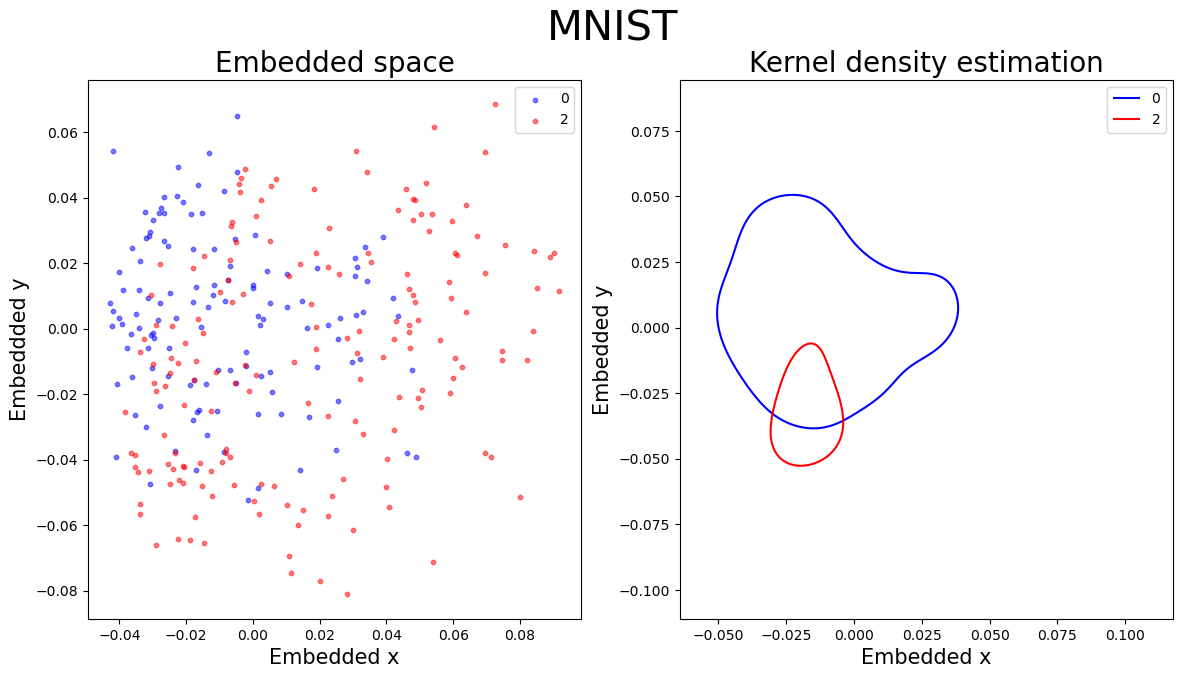

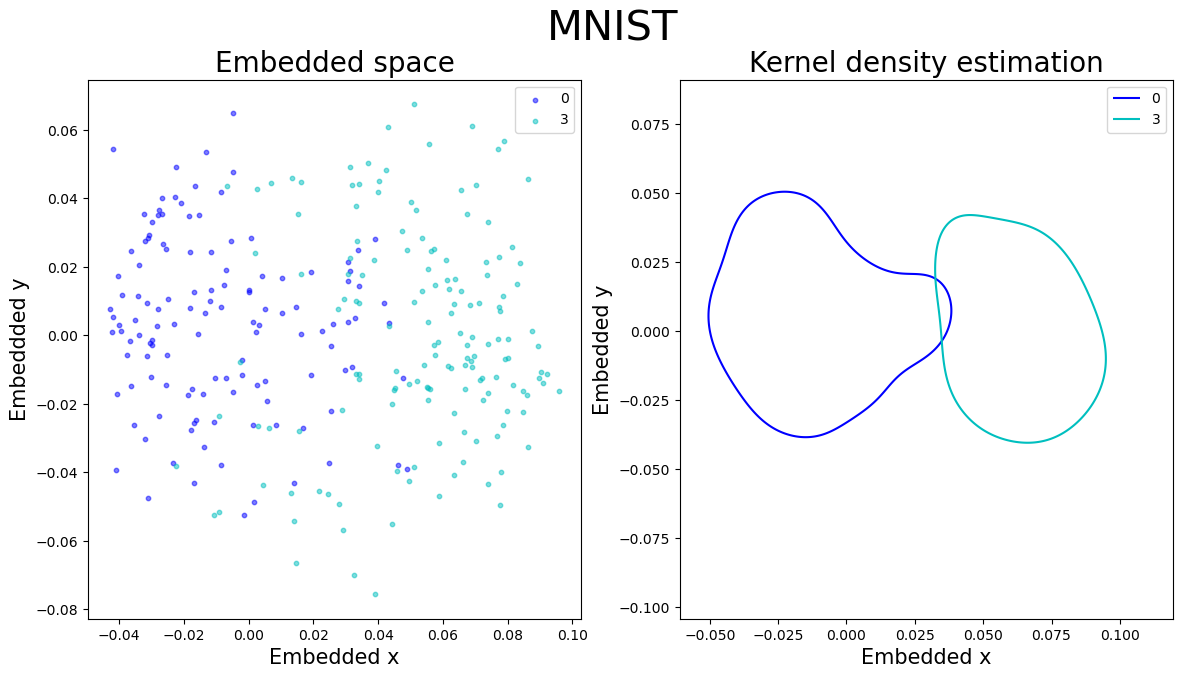

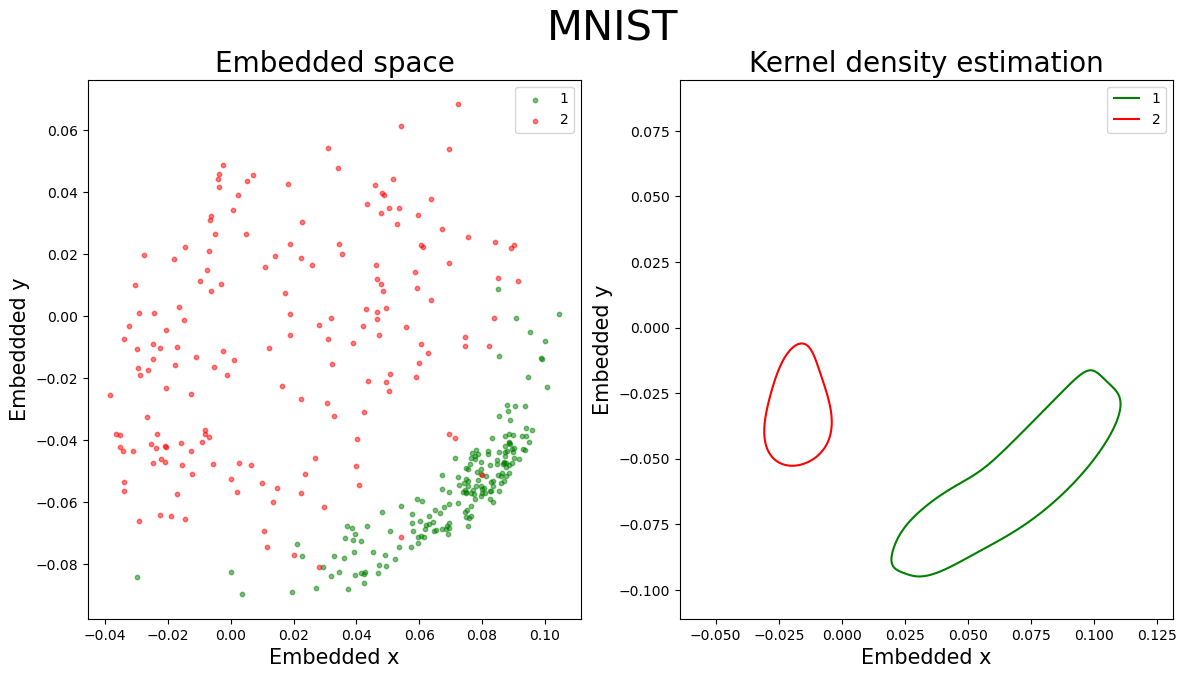

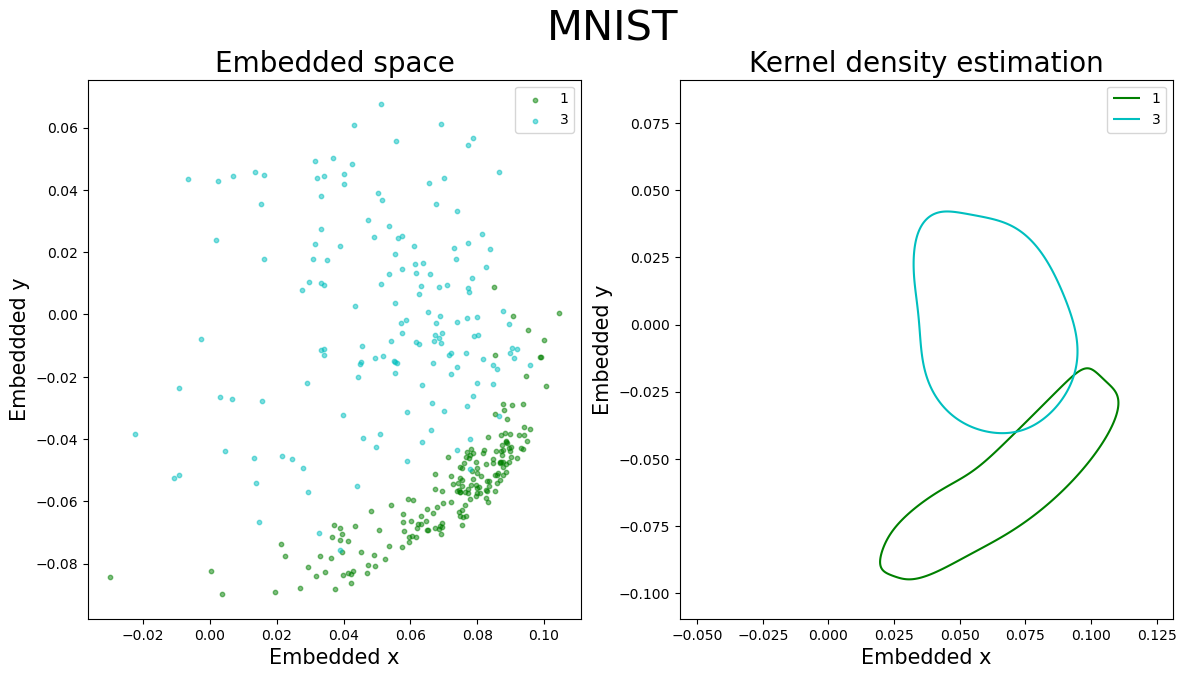

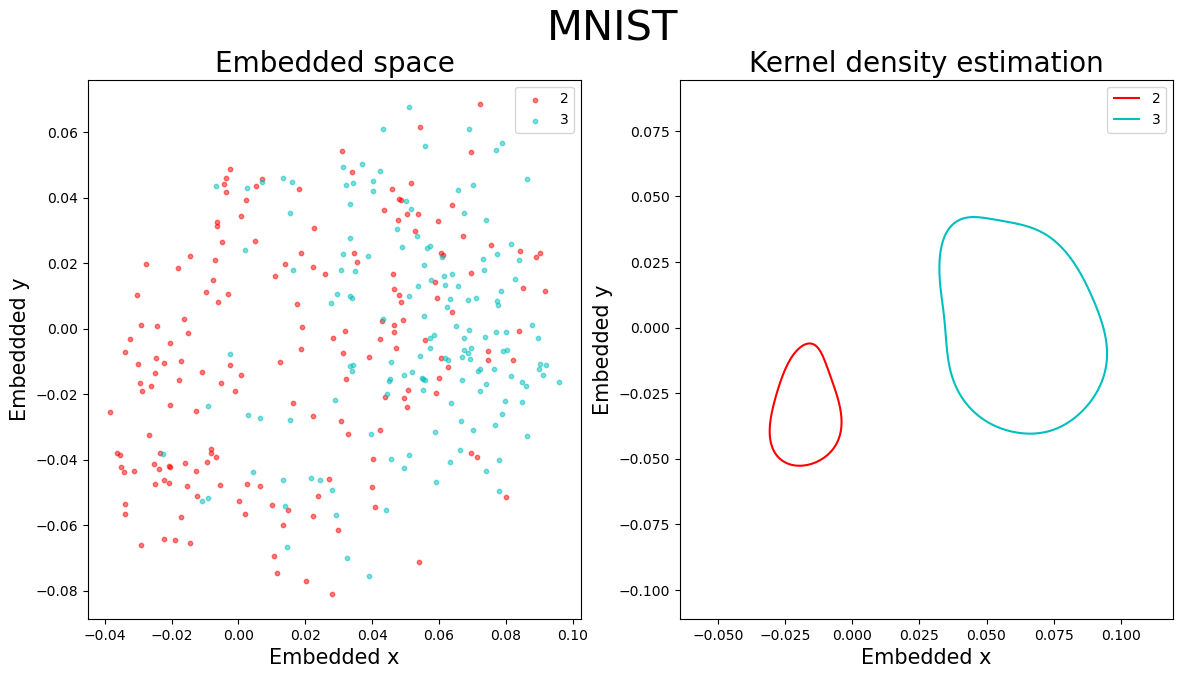

In [39]:
#------------------------------------------------------------------------------------PLOT
labels = ['1','2','3','4']

colors = ['g', 'r','c','m']

var, col = [], []

n_bullet = 0
n_target = 0

for n_bullet in [1,2,3,4]:
    for n_target in [1,2,3,4]:
        if n_target > n_bullet:
            fig_test = plt.figure(figsize=(14, 7), constrained_layout=False)
            gs_test = GridSpec(1, 2, figure = fig_test)

            fig_test.suptitle('MNIST', fontsize = 30)

            ax1_test = fig_test.add_subplot(gs_test[0, 1])
            ax1_test.set_title('Kernel density estimation', fontsize = 20)
            ax1_test.set_xlabel('Embedded x', fontsize = 15)
            ax1_test.set_ylabel('Embedded y', fontsize = 15)

            ax2_test = fig_test.add_subplot(gs_test[0,0])
            ax2_test.set_title('Embedded space', fontsize = 20)
            ax2_test.set_xlabel('Embedded x', fontsize = 15)
            ax2_test.set_ylabel('Embeddded y', fontsize = 15)

            for j in [n_bullet,n_target]:
                for i in range (sample_emb_test.size(0)):
                    if targets_test[i] == j:
                        ax2_test.scatter(sample_emb_test[i][0].cpu().detach().numpy(), sample_emb_test[i][1].cpu().detach().numpy(), color = colors[j], s=10, alpha = 0.5)
                var.append(labels[j])
                col.append(colors[j])

            ax2_test.legend(var,loc = 'best')

            leg = ax2_test.get_legend()    
            for i in range(len(var)):

                leg.legend_handles[i].set_color(col[i])
            #------------------------------------------------------KDE
            #fig, ax = plt.subplots()

            h = []

            for k in [n_bullet,n_target]:
                ind = torch.count_nonzero(targets_test == k)
                X = torch.zeros(1,1).expand(ind, 2).clone()

                l=0
                for i in range (sample_emb_test.size(0)):
                    if targets_test[i] == k:

                        X[l] = sample_emb_test[i]
                        l = l+1


                # Extract x and y
                x = X[:, 0]
                y = X[:, 1]

                # Define the borders
                deltaX = (torch.max(x) - torch.min(x))/5
                deltaY = (torch.max(y) - torch.min(y))/5
                xmin = torch.min(x).item() - deltaX.item()
                xmax = torch.max(x).item() + deltaX.item()
                ymin = torch.min(y).item() - deltaY.item()
                ymax = torch.max(y).item() + deltaX.item()

                # Create meshgrid
                xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

                x = x.detach().numpy()
                y = y.detach().numpy()

                positions = np.vstack([xx.ravel(), yy.ravel()])
                values = np.vstack([x, y])

                kernel = st.gaussian_kde(values)
                kernel.set_bandwidth(bw_method=0.5)

                f = np.reshape(kernel(positions).T, xx.shape)


                #ax1_test = plt.gca()
                cset = ax1_test.contour(xx, yy, f, levels = [80], colors=colors[k])
                h1, l1 = cset.legend_elements()
                h.append(h1[0])

            ax1_test.legend(h, var, loc = 'best', fontsize = 12)
            var, col, h = [], [], [] 
            #fig_test.savefig('/home/gbortolai/Thesis/Plot/MNIST/Emb/FCFF/MSE/KDE'+str([n_bullet,n_target])+'.pdf', facecolor='w',pad_inches=0.3, transparent=True)

In [ ]:
torch.save([sample_emb_test, targets_test],'/home/gbortolai/Thesis/data/MNIST/sample_emb_test_s='+str(test.size(0)))

In [10]:
#plotting E_dist emb

E = torch.triu(torch.cdist(sample_emb_test, sample_emb_test, p = 2))
torch.save([E, targets_test],'/home/gbortolai/Thesis/data/MNIST/E_dist_FCFF_2W_s='+str(test.size(0)))

RuntimeError: The expanded size of the tensor (2) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [2].  Tensor sizes: [3]

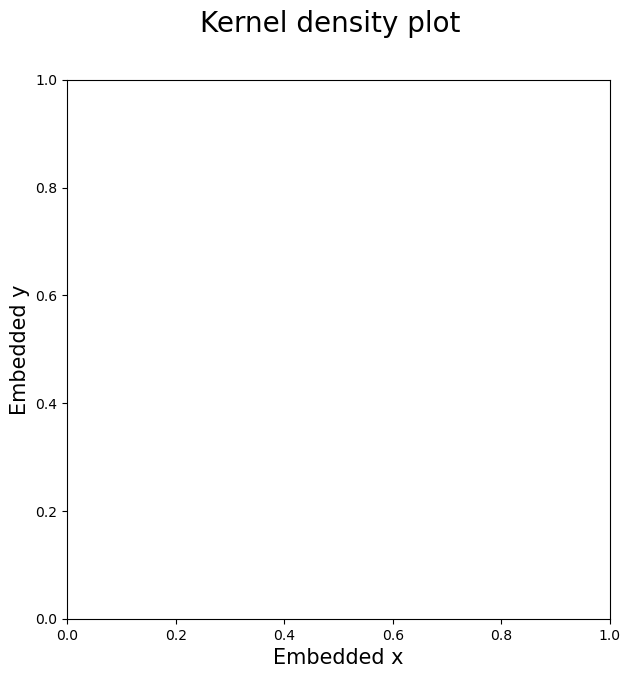

In [69]:
#SOLO KDE

labels = ['0','1','2','3','4','5','6','7','8','9']

colors = ['b', 'g', 'r','c','m','y','k', 'teal', 'purple', 'lime' ]

fig, ax = plt.subplots(1,1, figsize = (7,7))
fig.suptitle('Kernel density plot', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

lab = []
h = []

for k in [0,1,5,7,9]:
    ind = torch.count_nonzero(targets_test == k)
    X = torch.zeros(1,1).expand(ind, 2).clone()

    l=0
    for i in range (sample_emb_test.size(0)):
        if targets_test[i] == k:

            X[l] = sample_emb_test[i]
            l = l+1


    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # Define the borders
    deltaX = (torch.max(x) - torch.min(x))/5
    deltaY = (torch.max(y) - torch.min(y))/5
    xmin = torch.min(x).item() - deltaX.item()
    xmax = torch.max(x).item() + deltaX.item()
    ymin = torch.min(y).item() - deltaY.item()
    ymax = torch.max(y).item() + deltaX.item()

    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]

    x = x.detach().numpy()
    y = y.detach().numpy()

    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])

    kernel = st.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=0.5)

    f = np.reshape(kernel(positions).T, xx.shape)


    #ax1_test = plt.gca()
    #print(colors[k])
    cset = ax.contour(xx, yy, f, levels = [80], colors = colors[k])

    h1, l1 = cset.legend_elements()
    h.append(h1[0])
    lab.append(labels[k])

ax.legend(h, lab, loc = 'best', fontsize = 12)
# fig.savefig('/home/gbortolai/Thesis/Plot/MNIST/KDE_01579_myloss_FCFF.pdf', facecolor='w',pad_inches=0.3, transparent=True)
lab, h = [], []

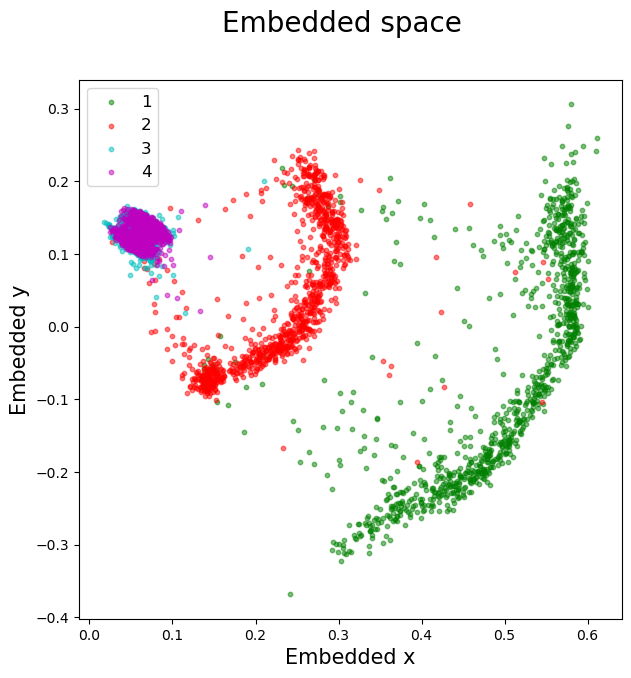

In [42]:
labels = ['1','2','3','4']

colors = ['g', 'r','c', 'm']

var, col = [], []
ampl = 1000

fig, ax = plt.subplots(1,1, figsize = (7,7))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize = (10,10))

fig.suptitle('Embedded space', fontsize = 20)
ax.set_xlabel('Embedded x', fontsize = 15)
ax.set_ylabel('Embedded y', fontsize = 15)

for j in [1, 2, 3, 4]:
    for i in torch.nonzero( targets_test == j)[:,0]:

                        # ax.scatter(ampl*sample_emb_test[i][0].cpu().detach().numpy(), ampl*sample_emb_test[i][1].cpu().detach().numpy(), ampl*sample_emb_test[i][2].cpu().detach().numpy(), s = 20, color = colors[j], alpha = 0.5)
                        ax.scatter(sample_emb_test[i][0].cpu().detach().numpy(), sample_emb_test[i][1].cpu().detach().numpy(), s = 10, color = colors[j - 1], alpha = 0.5)
    var.append(labels[j - 1])
    col.append(colors[j - 1])
    
ax.legend(var,loc = 'best', fontsize = 12)

leg = ax.get_legend()    
for i in range(len(var)):

    leg.legend_handles[i].set_color(col[i])
    
# fig.savefig('/home/gbortolai/Thesis/Plot/Jets/Embedded_FCFF.pdf', facecolor='w',pad_inches=0.3, transparent=True)
var, col = [], []